# Transfer Learning to assign categories to necklaces with VGG  

After deciding to use the VGG16 model, my goal was to then decide what kind of labels I on the images I would use. Did I need to categorize the necklaces by type, as Etsy had done? Or could I simply just separate necklace images from non-necklace images?   
  
This model tests the prior: I train the model to label the necklace into one of 5 categories:    
 - A beaded or pearl necklace 'beadedpearl'
 - A choker 'choker'
 - A large pendant or a necklace with a large pendant 'largependant'
 - A small pendant or a necklace with a small pendant 'smallpendant'
 - An image that has no necklace or a necklace that would not be identifiable easily 'throwaway'
  
Once I do this, I then use the model to produce feature vectors over which I calculate the similarity (described below by using LSH - which I later abandoned). At this point, I can compare the results to that produced by a model trained on categorical labels.  

In combination with LSH. Workflow:
1. Hand-label ~2000 images of necklaces
2. Train a model on them to some accuracy.
3. Download the model, predict categories.
4. Move those to the new category list.
5. Upload to google drive.
6. Retrain categorical model.  

  
*This code was written for use on Google Colab.*


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import os
import time

from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras import metrics, optimizers
%tensorflow_version 1.x
K.clear_session()

## Define paths & constants

In [ ]:
data_base_path = "/content/drive/My Drive/data/categorical_labeled/"
save_dir = os.path.abspath("/content/drive/My Drive/Colab Notebooks/")
categories = os.listdir(data_base_path)
print(categories)

['largependant', 'throwaway', 'choker', 'smallpendant', 'beadedpearl']


In [ ]:
for category in categories:
  print(len(os.listdir(data_base_path+category+"/")))

697
706
698
691
700


In [ ]:
nb_classes = len(categories)
batch_size = 32
nb_train_samples = batch_size*3
nb_validation_samples = batch_size*1
nb_epochs = 150

#IMAGE_RESIZE = 150
img_height = 150
img_width = 150

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [ ]:
accs = []
valaccs = []
losses = []
vallosses = []

## Preprocess data  
  
Randomly generate training & validation data

In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True, 
#    vertical_flip=True,
    rotation_range=40, 
    width_shift_range=.15,
    height_shift_range=.15,
#    zoom_range=0.5,
    validation_split=0.2) # set validation split

#test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_gen.flow_from_directory(
    data_base_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data
    # shuffles by default

validation_generator = train_gen.flow_from_directory(
    data_base_path, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 2791 images belonging to 5 classes.
Found 696 images belonging to 5 classes.


In [ ]:
#generator= train_datagen.flow_from_directory("train", batch_size=batch_size)
label_map = (train_generator.class_indices)
print(label_map)

{'beadedpearl': 0, 'choker': 1, 'largependant': 2, 'smallpendant': 3, 'throwaway': 4}


## Build model

In [ ]:
# Extract base of VGG16 model:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)

In [ ]:
# Add 3 trainable layers on top:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512*4, activation='relu'))
# EAM added a dropout layer
#model.add(Dropout(0.5))
model.add(Dense(512*4, activation='relu'))
# # EAM add regularizer
#model.add(Dense(512*4, input_dim=150,
#                 activity_regularizer=regularizers.l2(0.0)))
# # EAM added a dropout layer & an additional model layer
# model.add(Dropout(0.5))
#model.add(Dense(512*4, activation='relu'))

# predict category
model.add(Dense(nb_classes, activation='softmax'))

conv_base.trainable = True
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 32
This is the number of trainable weights after freezing the conv base: 6


### Inspect a batch

In [ ]:
sample_training_images, _ = next(train_generator)

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

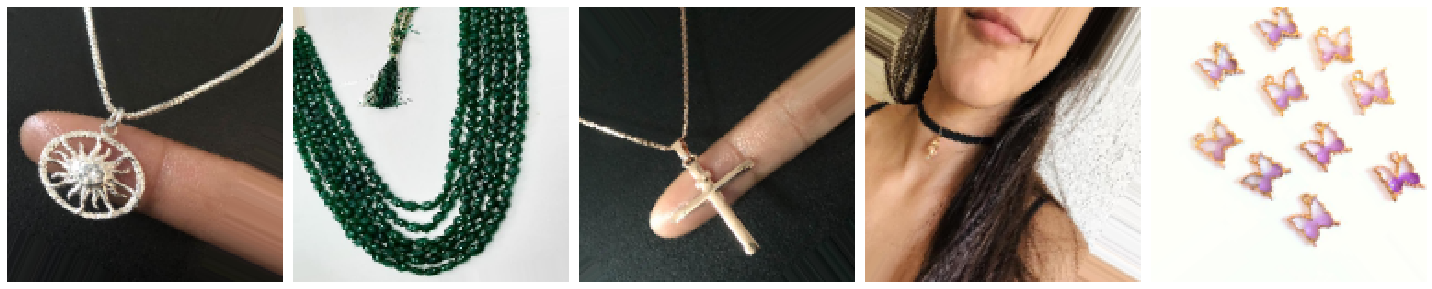

In [ ]:
plotImages(sample_training_images[:5])

## Compile transfer learning model

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              16779264  
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 10245     
Total params: 35,700,549
Trainable params: 20,985,861
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
#LR1 = 0.001 # default with adam
#LR2 = 0.01
adam = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#rmsprop = optimizers.RMSprop(learning_rate=0.0001)
#sgd = optimizers.SGD(learning_rate=0.0001, momentum=0.0, nesterov=False)
#model.compile(optimizer = sgd, 
#model.compile(optimizer = 'adam', 
model.compile(optimizer = adam, 
              loss = 'categorical_crossentropy',  # for labeled data
              metrics = ['acc',f1_m,precision_m, recall_m])

## Train our model

In [ ]:
start_time = time.time()
fit_history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=nb_epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)
end_time = time.time()
print("Total Time: "+str(end_time - start_time)+" seconds.");

Epoch 1/150
3/3 [==============================] - 24s 8s/step - loss: 1.8187 - acc: 0.2083 - f1_m: 0.0202 - precision_m: 0.3333 - recall_m: 0.0104 - val_loss: 1.8903 - val_acc: 0.3750 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/150
3/3 [==============================] - 12s 4s/step - loss: 1.7212 - acc: 0.3021 - f1_m: 0.0741 - precision_m: 0.3333 - recall_m: 0.0417 - val_loss: 1.9574 - val_acc: 0.3125 - val_f1_m: 0.1111 - val_precision_m: 0.5000 - val_recall_m: 0.0625
Epoch 3/150
3/3 [==============================] - 18s 6s/step - loss: 1.5600 - acc: 0.4062 - f1_m: 0.3317 - precision_m: 0.7808 - recall_m: 0.2188 - val_loss: 1.3190 - val_acc: 0.3750 - val_f1_m: 0.2564 - val_precision_m: 0.7143 - val_recall_m: 0.1562
Epoch 4/150
3/3 [==============================] - 18s 6s/step - loss: 1.2611 - acc: 0.4896 - f1_m: 0.3252 - precision_m: 0.7407 - recall_m: 0.2083 - val_loss: 1.3560 - val_acc: 0.4375 - val_f1_m: 0.3846 - val_precision_m: 0.5000

In [ ]:
#save_dir = os.path.join(os.getcwd(),'/drive/My Drive/Colab Notebooks/models/')
#print(save_dir)

/content/drive/My Drive/Colab Notebooks


In [ ]:
import pickle
model.save(save_dir+'/../data/VGG_categorical_classifier_larger_dataset.h5')
fit_history.history['time_total'] = end_time - start_time
fit_history.history['category_labels'] = label_map
pickle.dump(fit_history.history,open(save_dir+'/../data/VGG_categorical_classifier_larger_dataset.pkl','wb'))

In [ ]:
os.getcwd()

'/content'

## Visualize model metrics

In [ ]:
#print(fit_history.history.keys())
acc = fit_history.history['acc']
val_acc = fit_history.history['val_acc']

loss = fit_history.history['loss']
val_loss = fit_history.history['val_loss']


In [ ]:
# round 1: 2 dropout layers (0.5, 0.5) + L2 regularization layer
# round 2: remove dropout & regularization layers. 
# round 3: remove one layer (so now only 2 layers + prediction layer)
# round 4: replace a prediction layer with a dropout layer
# round 5: extend number of epochs to 150
# round 6: 150 epochs + dropout layer + 2 layers
# round 7: 150 epochs, dropout layer, 2 layers, and LR = 1e-4
# round 8: 100 epochs, 2 layers, LR = 1e-4 (Adam)
# round 9: 100 epochs, 2 layers, LR = 1e-4, (RMSprop)
# round 10: 100 epochs, 2 layers, dropout layer, LR = 1e-4, (RMSprop)
# round 11: 100 epochs, 2 layers, LR = 1e-5, (adam)
# round 12: 150 epochs, 2 layers, LR = 1e-5, (adam)
accs.append(np.mean(acc[-15:]))
valaccs.append(np.mean(val_acc[-15:]))
losses.append(np.mean(loss[-15:]))
vallosses.append(np.mean(valloss[-15:]))


# print(np.mean(acc[-15:]))
# print(np.mean(val_acc[-15:]))

In [ ]:
print(accs)
print(valaccs)

[0.539016, 0.6421264, 0.6777777, 0.6406593, 0.7157081, 0.5902778, 0.6993056, 0.69604856, 0.74674296, 0.6013889, 0.64305556, 0.65614235]
[0.5416667, 0.5708333, 0.58958334, 0.57916665, 0.5395833, 0.5708333, 0.6, 0.65, 0.6479167, 0.65416664, 0.64375, 0.675]


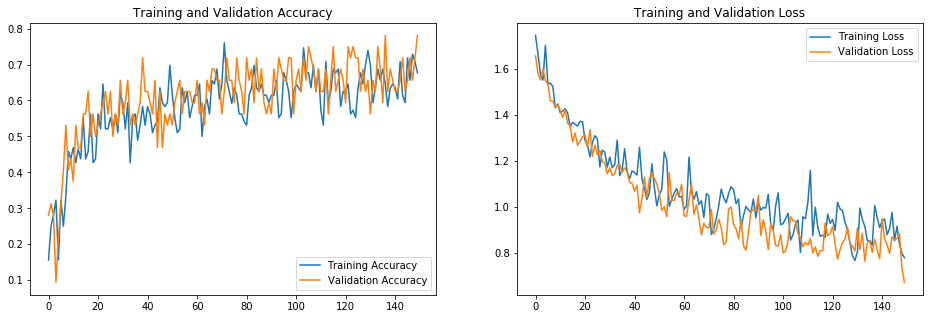

In [ ]:

epochs_range = range(nb_epochs)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.savefig('./VGG.binary.v7.png')
plt.show()